In [1]:
!gdown 1TovneWlWJsjTr95m7C0284bcephlixj2
!gdown 1IVDppeuLIRESFVjELv6cGO6ExuCUFxwr

Downloading...
From: https://drive.google.com/uc?id=1TovneWlWJsjTr95m7C0284bcephlixj2
To: /content/kmeans_model_for_BOVW_clustering_celeb.sav
100% 33.1M/33.1M [00:00<00:00, 89.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1IVDppeuLIRESFVjELv6cGO6ExuCUFxwr
To: /content/models_for_face_extraction_celeb.zip
100% 8.00M/8.00M [00:00<00:00, 33.3MB/s]


In [2]:
!gdown 16XcnEbSH4OijzCchTcZuyj3-KfXAdcAp
!gdown 1xB5ukiVDAr32TKH3Oz5ZvdIiVanhegl2

Downloading...
From: https://drive.google.com/uc?id=16XcnEbSH4OijzCchTcZuyj3-KfXAdcAp
To: /content/cebeldataset_big.csv
100% 469k/469k [00:00<00:00, 61.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xB5ukiVDAr32TKH3Oz5ZvdIiVanhegl2
To: /content/BIG_Celeb.zip
100% 528M/528M [00:06<00:00, 79.2MB/s]


In [3]:
%%capture
!wget https://engineering.unl.edu/images/staff/Kayla-Person.jpg
!wget https://www.dmarge.com/wp-content/uploads/2021/01/dwayne-the-rock-.jpg

In [4]:
%%capture
!pip install chitra
!pip install -U opencv-python

In [5]:
%%capture
!unzip models_for_face_extraction_celeb.zip
!unzip BIG_Celeb.zip -d ./celeb_data

In [8]:
%%capture
!unzip models_for_face_extraction_celeb.zip

In [6]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from random import randrange
from skimage import io
from PIL import Image 
import pandas as pd
import numpy as np
import pickle
import cv2
from chitra.image import Chitra
from sklearn.model_selection import train_test_split


In [9]:
### for feature extraction (BOWV) ###
feature_extractor = cv2.SIFT_create()
kmeans = pickle.load(open('kmeans_model_for_BOVW_clustering_celeb.sav', 'rb'))
num_visual_words = 512

### for bounding box generation ###
grad_boost = pickle.load(open('/content/models/gradient_model.sav', 'rb'))
knnRegressor = pickle.load(open('/content/models/knnRegression.sav', 'rb'))
simpleNN = pickle.load(open('/content/models/simpleNN.sav', 'rb'))

In [15]:
def get_bowv_from_img(img_path):
  imagem_data = io.imread(img_path) 
  inicial_img_shape = imagem_data.shape
  imagem_data = cv2.cvtColor(imagem_data, cv2.COLOR_BGR2RGB)
  resize_img = cv2.resize(imagem_data, (480,480))
  _, sift_vectors = feature_extractor.detectAndCompute(resize_img, None)

  hist = kmeans.predict(sift_vectors)
  hist = np.histogram(hist, num_visual_words)[0]

  return hist, resize_img, inicial_img_shape

def increase_by(val, to_inc):
  val += val * to_inc
  return min(val, 480)  

def decrese_by(val, to_inc):
  val -= val * to_inc
  return max(val, 0)

def expand_box(box, by_p=0.2):
  box[0] = decrese_by(box[0], by_p)
  box[1] = decrese_by(box[1], by_p)

  box[2] = increase_by(box[2], by_p)
  box[3] = increase_by(box[3], by_p)

def get_prediction_for_image(img_path, display=False, exp_by=0.0):

  bowv, resized_img, inicial_img_shape = get_bowv_from_img(img_path)

  bowv = bowv/sum(bowv)

  gra_boost_pred = grad_boost.predict(np.array([bowv]))[0] * 480
  knnRegressor_pred = knnRegressor.predict(np.array([bowv]))[0] * 480
  simpleNN_pred = simpleNN.predict(np.array([bowv]))[0] * 480
  
  expand_box(gra_boost_pred, exp_by)
  expand_box(knnRegressor_pred, exp_by)
  expand_box(simpleNN_pred, exp_by)
  
  image_grad_boost = Chitra(np.array(resized_img), bboxes=gra_boost_pred, labels='face')
  image_grad_boost.resize_image_with_bbox((inicial_img_shape[1], inicial_img_shape[0]))
  
  image_knn = Chitra(np.array(resized_img), bboxes=knnRegressor_pred, labels='face')
  image_knn.resize_image_with_bbox((inicial_img_shape[1], inicial_img_shape[0]))

  image_NN = Chitra(np.array(resized_img), bboxes=simpleNN_pred, labels='face')
  image_NN.resize_image_with_bbox((inicial_img_shape[1], inicial_img_shape[0]))

  return image_grad_boost, image_knn, image_NN

def plot_images(image_grad_boost, image_knn, image_NN, plot_shape=(20,3), save_fig=False):

  plt.rcParams["figure.figsize"] = plot_shape
  fig, axs = plt.subplots(1,3)
  # fig.suptitle('images results')
  
  axs[0].imshow(cv2.cvtColor(image_grad_boost.draw_boxes(), cv2.COLOR_BGR2RGB))
  axs[0].set_title('Grad boost results')
  axs[1].imshow(cv2.cvtColor(image_knn.draw_boxes(), cv2.COLOR_BGR2RGB))
  axs[1].set_title('KNN results')
  axs[2].imshow(cv2.cvtColor(image_NN.draw_boxes(), cv2.COLOR_BGR2RGB))
  axs[2].set_title('Simple NN results')

  fig.patch.set_alpha(0.0)
  fig.show()
  if save_fig:
    cv2.imwrite('grad_boost_result.png', image_grad_boost.draw_boxes())
    cv2.imwrite('image_knn_result.png', image_knn.draw_boxes())
    cv2.imwrite('image_NN_result.png', image_NN.draw_boxes())

In [16]:
image_grad_boost, image_knn, image_NN = get_prediction_for_image('/content/Kayla-Person.jpg', exp_by=0.1)

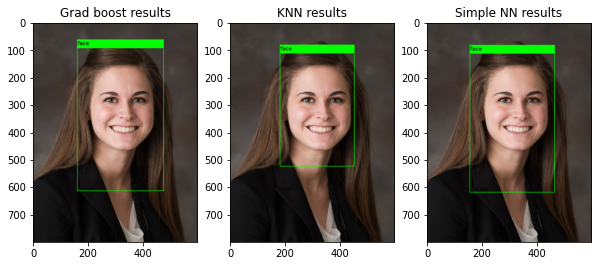

In [17]:
plot_images(image_grad_boost, image_knn, image_NN, plot_shape=(10,5), save_fig=True)

In [18]:
df = pd.read_csv('/content/cebeldataset_big.csv')
_, df_test = train_test_split(df, test_size=0.3, random_state=42)
df_test.head(1)

,img_name,x1,y1,w,h,x2,y2
5809,./celeb_data/005810.jpg,430,691,1222,1692,1652,2383


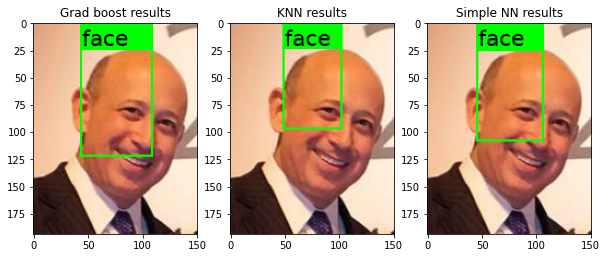

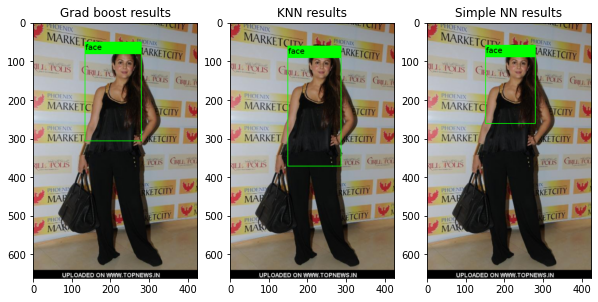

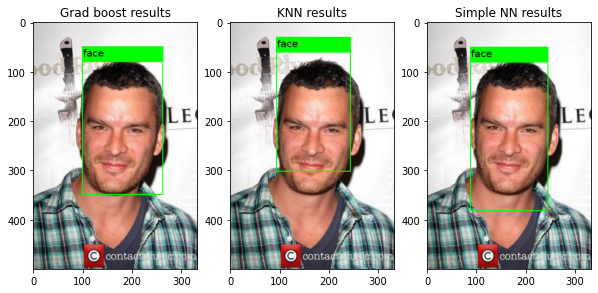

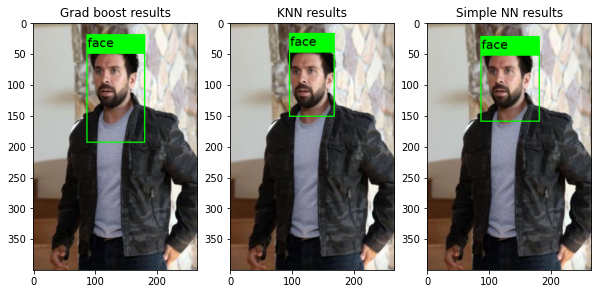

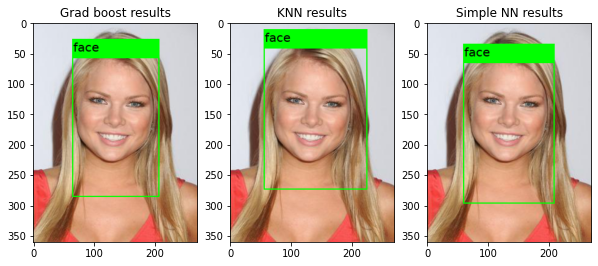

In [19]:
images_path = df_test['img_name'].sample(5,random_state=1).values

for cur_img_p in images_path:
  image_grad_boost, image_knn, image_NN = get_prediction_for_image(cur_img_p, exp_by=0.0)
  plot_images(image_grad_boost, image_knn, image_NN, plot_shape=(10,5), save_fig=True)

